# Complete Pipeline Example

This notebook demonstrates running the full mono-cbp pipeline from start to finish.

## Setup

First, import the necessary modules and define paths:

In [1]:
import logging
from mono_cbp import MonoCBPPipeline
import os

# Configure logging before using the pipeline
logging.basicConfig(
    level=logging.INFO,  # Show INFO and above
    format='%(asctime)s | %(levelname)-8s | %(name)s | %(message)s',
    datefmt='%H:%M:%S'
)

# Define paths
CATALOGUE_PATH = '../catalogues/TEBC_morph_05_P_7_ADJUSTED.csv'
DATA_DIR = '../data'
SECTOR_TIMES_PATH = '../catalogues/sector_times.csv'
OUTPUT_DIR = 'results'

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Configuration

Define the pipeline configuration:

In [2]:
config = {
    'transit_finding': {
        'mad_threshold': 3,
        'detrending_method': 'cb',
        'generate_vetting_plots': True,
        'generate_skye_plots': True,
        'save_event_snippets': True,
        'filters': {
            'min_snr': 5.0,
            'max_duration_days': 1.0,
        }
    },
    'model_comparison': {
        'tune': 1000,
        'draws': 1000,
        'chains': 4,
        'cores': 4,
        'save_plots': True,
        'plot_dir': f'{OUTPUT_DIR}/model_comparison_plots',
    }
}

## Initialize Pipeline

Create the pipeline object:

In [3]:
pipeline = MonoCBPPipeline(
    catalogue_path=CATALOGUE_PATH,
    data_dir=DATA_DIR,
    sector_times_path=SECTOR_TIMES_PATH,
    TEBC=True,
    config=config
)

17:53:55 | INFO     | mono_cbp.utils.data | Loaded catalogue with 592 targets from ../catalogues/TEBC_morph_05_P_7_ADJUSTED.csv
17:53:55 | INFO     | mono_cbp.pipeline | Initialized pipeline with 592 targets
17:53:55 | INFO     | mono_cbp.eclipse_masking | Initialized EclipseMasker with data directory: ../data
17:53:55 | INFO     | mono_cbp.transit_finding | Loaded sector times from ../catalogues/sector_times.csv
17:53:55 | INFO     | mono_cbp.model_comparison | Initialized ModelComparator
17:53:55 | INFO     | mono_cbp.pipeline | Transit models not provided - injection-retrieval will not be available


## Run Pipeline

Execute the complete pipeline:

The pipeline runs in 3 steps:
1. **Eclipse masking** (always runs) - Identifies and masks primary/secondary eclipses
2. **Transit finding** (`find_transits=True`) - Detects transit candidates
3. **Model comparison** (`vet_candidates=True`) - Bayesian vetting (computationally expensive)

**Common configurations:**
- Quick exploration: `find_transits=True, vet_candidates=False` (used below)
- Full pipeline: `find_transits=True, vet_candidates=True`
- Eclipse masking only: `find_transits=False, vet_candidates=False`

In [4]:
results = pipeline.run(
    find_transits=True,
    vet_candidates=False,
    mask_eclipses_kwargs={'force': True},
    find_transits_kwargs={'plot_output_dir': f'{OUTPUT_DIR}/vetting_plots'}
)

17:54:00 | INFO     | mono_cbp.pipeline | Starting mono-cbp pipeline
17:54:00 | INFO     | mono_cbp.pipeline | Step 1: Eclipse masking
17:54:00 | INFO     | mono_cbp.eclipse_masking | Processing 2 files in ../data
17:54:00 | INFO     | mono_cbp.eclipse_masking | Saved eclipse mask to TIC_260128333_06.npz
17:54:00 | INFO     | mono_cbp.eclipse_masking | Saved eclipse mask to TIC_260128333_07.npz
17:54:00 | INFO     | mono_cbp.pipeline | Eclipse masking complete
17:54:00 | INFO     | mono_cbp.pipeline | Step 2: Transit finding
17:54:00 | INFO     | mono_cbp.transit_finding | Processing files in ../data
17:54:00 | INFO     | mono_cbp.transit_finding | Found 2 files to process
17:54:00 | INFO     | mono_cbp.transit_finding | Progress: 0/2
17:54:01 | INFO     | mono_cbp.utils.detrending | TIC_260128333_06 cos + biweight
17:54:01 | INFO     | mono_cbp.utils.detrending | Cosine window length: 2.1 days
17:54:01 | INFO     | mono_cbp.utils.plotting | Saved event plot to results/vetting_plots/TI

In [ ]:
TCE_search = pipeline.find_transits()
vetting_results = pipeline.vet_candidates()
vetting_results

## Results

Display and analyze the results:

In [5]:
print("="*60)
print("PIPELINE RESULTS")
print("="*60)

# Get the actual DataFrames from the pipeline results
transit_df = results.get('transit_finding')
vetting_df = results.get('vetting')

# Calculate statistics from the DataFrames
n_systems = len(pipeline.catalogue)
n_events = len(transit_df) if transit_df is not None else 0
n_vetted = len(vetting_df) if vetting_df is not None else 0

# Count high-confidence candidates (classification 'T' or 'AT')
if vetting_df is not None and len(vetting_df) > 0:
    n_candidates = len(vetting_df[vetting_df['best_fit'].isin(['T', 'AT'])])
else:
    n_candidates = 0

print(f"Systems in catalogue: {n_systems}")
print(f"TCEs detected: {n_events}")
print(f"Events vetted: {n_vetted}")
print(f"High-confidence candidates: {n_candidates}")

PIPELINE RESULTS
Systems in catalogue: 592
TCEs detected: 3
Events vetted: 0
High-confidence candidates: 0


In [6]:
# Filter transit_df for events that are not flagged by Skye metric or detrending dependence flags
# Use Series.astype(int) (or pd.to_numeric) on each column rather than int(...) on the whole Series
transit_df_filtered = transit_df[
	(transit_df['det_dependence'].astype(int) == 0) &
	(transit_df['skye_flag'].astype(int) == 0) & 
    (transit_df['snr'].astype(float) >= pipeline.config['transit_finding']['filters']['min_snr']) &
    (transit_df['duration'].astype(float) <= pipeline.config['transit_finding']['filters']['max_duration_days'])
]

print(f"TCEs after filtering detrending dependence and Skye flags: {len(transit_df_filtered)}")

TCEs after filtering detrending dependence and Skye flags: 1


In [ ]:
print(transit_df[transit_df['tic'] == '260128333'])

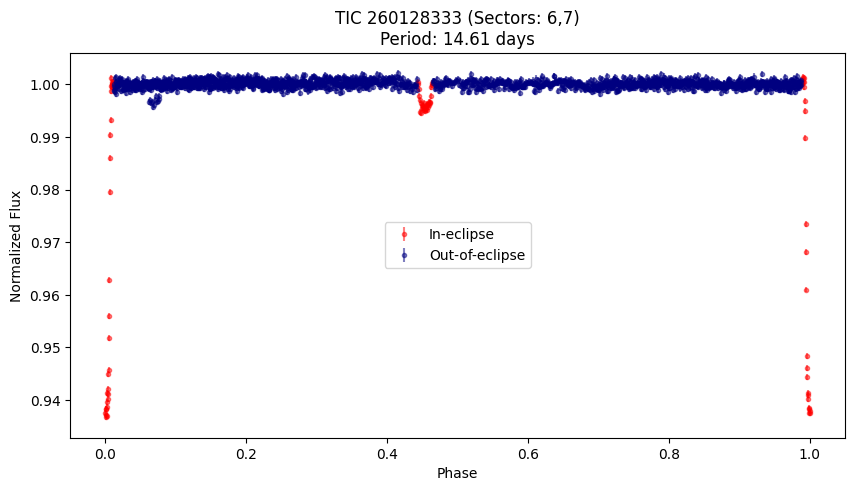

In [7]:
pipeline.plot_bin_phase_fold(260128333)

### Detected Events

Plot the detected transit events:

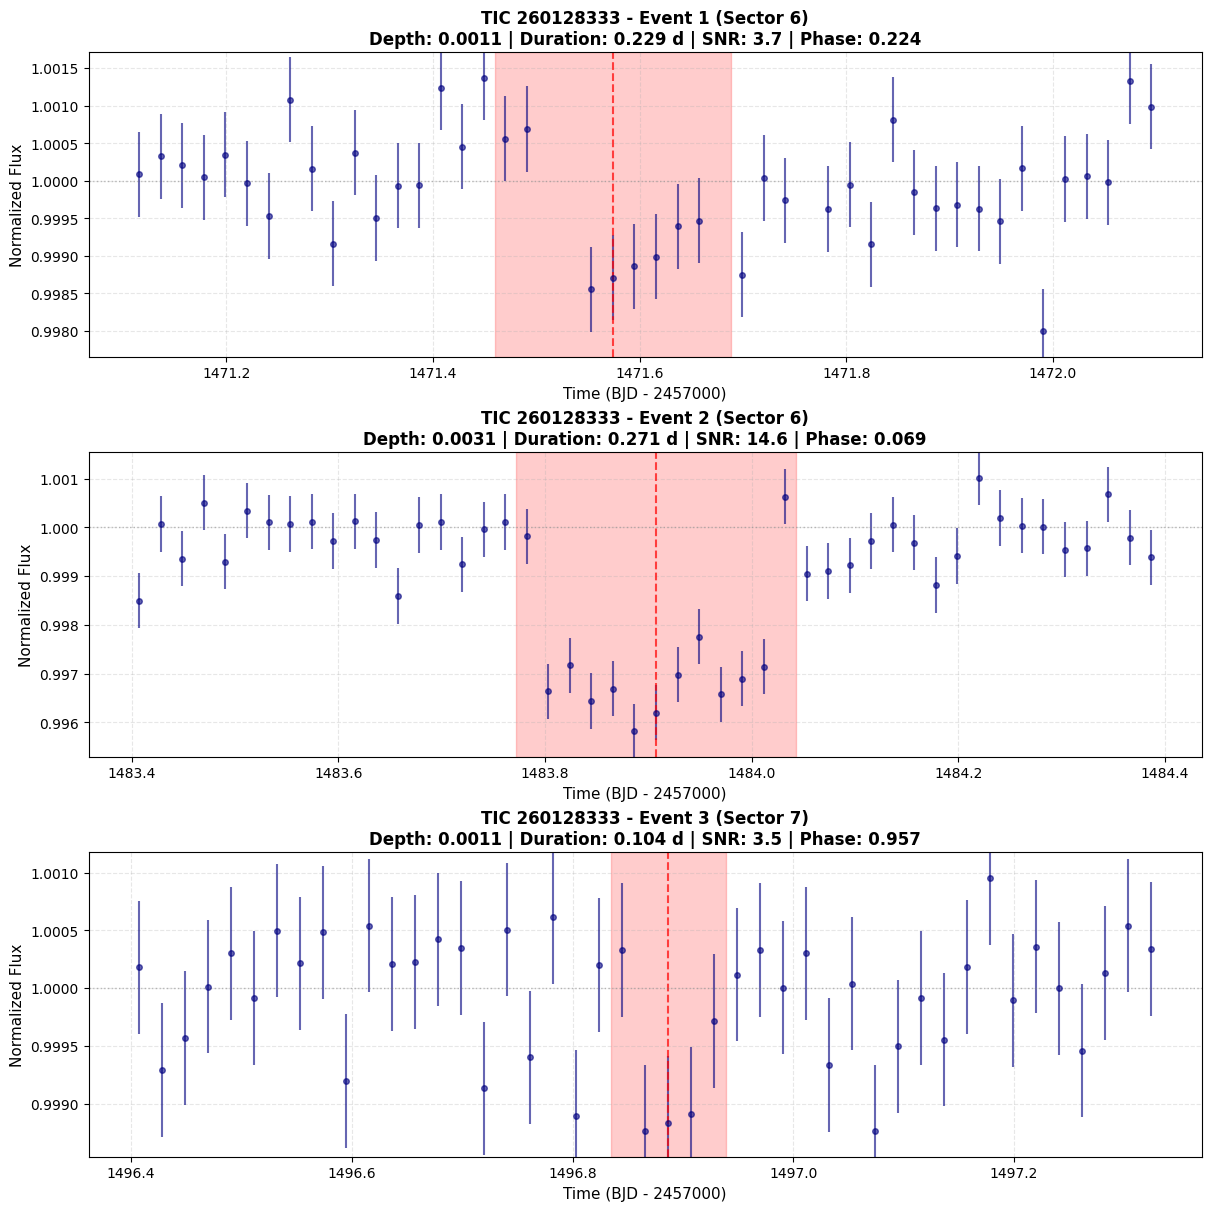

In [8]:
# Plot all detected events for TIC 260128333 (TOI-1338)
pipeline.plot_events(260128333)

### Candidate Details

In [ ]:
# Display high-confidence candidates (T or AT classifications)
if vetting_df is not None and len(vetting_df) > 0:
    # Filter for high-confidence candidates
    candidates_df = vetting_df[vetting_df['best_fit'].isin(['T', 'AT'])]
    
    if len(candidates_df) > 0:
        print("HIGH-CONFIDENCE CANDIDATES:")
        print("-" * 60)
        
        # Merge with transit data to get event details
        if transit_df is not None:
            for i, row in enumerate(candidates_df.iterrows(), 1):
                idx, candidate = row
                # Extract TIC and sector from filename (format: TIC_XXXXX_S#_event#.npz)
                filename = candidate['filename']
                parts = filename.replace('.npz', '').split('_')
                
                print(f"{i}. {parts[0]} {parts[1]} (Sector {parts[2]}, Event {parts[3]})")
                print(f"   Classification: {candidate['best_fit']}")
                print(f"   AIC - Transit: {candidate['aic_transit']:.1f}")
                print(f"   AIC - Sinusoid: {candidate['aic_sinusoidal']:.1f}")
                print(f"   AIC - Linear: {candidate['aic_linear']:.1f}")
                print(f"   AIC - Step: {candidate['aic_step']:.1f}")
                print(f"   RMSE (Transit): {candidate['rmse_transit']:.2f}")
                print()
        else:
            print(f"Found {len(candidates_df)} high-confidence candidates")
            print("(Transit data not available for details)")
    else:
        print("No high-confidence candidates found.")
        print(f"\nClassification breakdown:")
        print(vetting_df['best_fit'].value_counts())
else:
    print("No vetting results available.")

### Output Files

Results are saved to the following locations:

In [ ]:
print("Results saved to:")
print(f"  - Transit events: {OUTPUT_DIR}/transit_events.txt")
print(f"  - Classifications: {OUTPUT_DIR}/vetting_results.csv")
print(f"  - Vetting plots: {OUTPUT_DIR}/vetting_plots/")
print(f"  - Model comparison plots: {OUTPUT_DIR}/model_comparison_plots/")